# Data processing 

## settings

### libraries

In [68]:
import numpy as np
import pandas as pd
import math
import cv2
import random
import os
import torch
from PIL import Image, ImageOps
import pickle
import torchvision
import torchvision.models as models
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import ndimage
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [69]:
# paths
path_aerial = "pkl_stat\semel_stat_to_np" # path of aerial data
path_area = "data/area.csv"
path_stat_area_response = "data/stat_area_response.csv"
model_path =  "trained models\model.pth"

### Aerial Data
Processed in `data_collection.ipynb` (pkl, each dictionary contains a statistical area encoded as a `np.array` with 4 channels; each pixel represents a 10m area made up of RGB and NIR bands).

In [70]:
pickle_files = [os.path.join( path_aerial,f)  for f in os.listdir(path_aerial) if f.endswith('.pkl')]
print(pickle_files[:2])

['pkl_stat\\semel_stat_to_np\\statistical_areas_batch_1.pkl', 'pkl_stat\\semel_stat_to_np\\statistical_areas_batch_10.pkl']


### Response Varible Data
- **response**:  labels for each statistical area. We will use the socio-economic score and population data.
- **Area**: the size of each statistical area to calculate population density.

In [71]:
area = pd.read_csv(path_area)
response = pd.read_csv(path_stat_area_response, encoding='windows-1255')
Col_name = ['ערך מדד 2021','אוכלוסיית המדד 2021']
col1 = response.columns[1]
col2 = 'סמל אזור סטטיסטי'
area_dict =  area.set_index(area["SEMEL_YISH"].astype(int).astype(str) + ' ' + area["STAT_2022"].astype(str))['SHAPE_Area'].to_dict()

## Processing

## Data preparation

### Functions for Row Filtering and Image Size Adjustment

- **`check_row`**: Checks if specific column values in a row match a set of target values.
- **`creat_lebles`**: Filters a DataFrame based on matching values and creates a dictionary of labels from specific columns.
- **`randomaly_crop`**: Crops a NumPy array to a target size randomly, ensuring the array size matches the required dimensions.
- **`add_zeros`**: Pads a NumPy array with zeros to reach a target size if its dimensions are smaller.
- **`adjust_size`**: Iterates over a dictionary of NumPy arrays, ensuring that each array is resized or cropped to the target dimensions.

In [72]:
def check_row(row,val0,val1,col1,col2):
    for i in range(len(val0)):
        if val0[i] == row[col1] and val1[i] == row[col2]  :
            return True
    return False

def creat_lebles(VALS,Response,Col_name):
    VALS0 = [float(i[0]) for i in VALS]
    VALS1 = [float(i[1]) for i in VALS]
    col1 = Response.columns[1]
    col2 = 'סמל אזור סטטיסטי'
    
    df_extracted =Response[Response.apply(check_row, axis=1, args=(VALS0, VALS1,col1,col2))]
    Labels = df_extracted.set_index(df_extracted[col1].astype(int).astype(str) + ' ' + df_extracted[col2].astype(str))[Col_name].to_dict()
    return Labels

def randomaly_crop(np_array, target_size=224):
    H, W, C = np_array.shape
    if H < target_size or W < target_size:
        np_array = add_zeros(np_array, target_size=224)
        H, W, C = np_array.shape
    start_h = np.random.randint(0, H - target_size + 1)
    start_w = np.random.randint(0, W - target_size + 1)
    np_array = np_array[start_h:start_h + target_size, start_w:start_w + target_size, :]
    return np_array

def add_zeros(np_array, target_size=224):
    H, W, C = np_array.shape
    pad_h = max(target_size - H, 0)
    pad_w = max(target_size - W, 0)
    
    # Randomly choose whether to pad at the top or bottom, left or right
    pad_top = random.randint(0, pad_h)
    pad_bottom = pad_h - pad_top
    pad_left = random.randint(0, pad_w)
    pad_right = pad_w - pad_left

    np_array = np.pad(
        np_array,
        ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
        mode='constant',
        constant_values=0
    )
    
    return np_array

def adjust_size(original_img):
    if (original_img.shape)[0] < 224 and (original_img.shape)[1] < 224:
        original_img = add_zeros(original_img, target_size = 224)
    else:
        original_img = randomaly_crop(original_img, target_size = 224)
    return original_img

# def adjust_size(filtered_data):
#     for i in filtered_data.keys():
#         if (filtered_data[i].shape)[0] < 224 and (filtered_data[i].shape)[1] < 224:
#             filtered_data[i] = add_zeros(filtered_data[i], target_size = 224)
#         else:
#             filtered_data[i] = randomaly_crop(filtered_data[i], target_size = 224)
#     return filtered_data
        

### Filter and Resize Pickle Files by Labels

data loaded


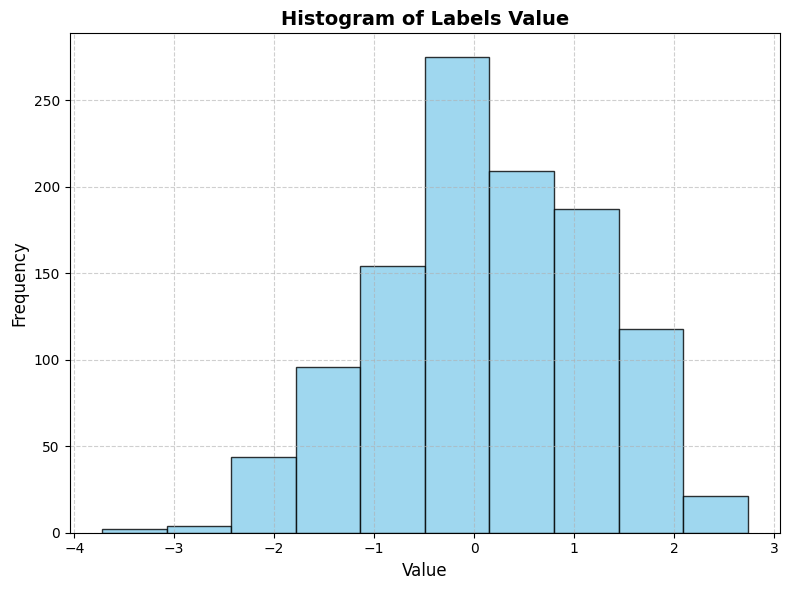

In [76]:
def load_pickle_by_label(response_df = response, Desired_label = Col_name[0]):
    Labels = {}
    filtered_data = {}
    for i, path_of_pkl in enumerate(pickle_files):
        with open(pickle_files[i], 'rb') as f:
            data = pickle.load(f)
        VALS = [STR.split() for STR in data.keys()]
        Labels.update(creat_lebles(VALS,response_df, Desired_label))
        data_match_labels = {k: v for k, v in data.items() if k in Labels.keys()}
        filtered_data.update(data_match_labels)

        
    if Desired_label == Col_name[1]:
            Labels =  {
            str(key.split(" ")[0]) + " " + str(int(float(key.split(" ")[1]))): value
            for key, value in Labels.items()
        }
            for k in Labels.keys():
                temp = Labels[k]
                Labels[k] = (float(temp.replace(",", ""))/area_dict[k])*100 # avoid numbers close to zero
            Labels =  {
            str(key.split(" ")[0]) + " " + str(float((key.split(" ")[1]))) : value
            for key, value in Labels.items()
        }
    print("data loaded")
    return Labels , filtered_data
    
Labels, filtered_data = load_pickle_by_label()

def create_hist_of_labels(labels):
    """
    Function to create a histogram from the values of a dictionary.
    
    Parameters:
    labels (dict): A dictionary where values will be used for the histogram.
    """
    # Extract the values from the dictionary
    data = list(labels.values())

    # Create the histogram
    plt.figure(figsize=(8, 6))  # Adjust the figure size for better readability
    plt.hist(data, bins=10, edgecolor='black', alpha=0.8, color='skyblue')
    
    # Add title and labels with clearer formatting
    plt.title('Histogram of Labels Value', fontsize=14, fontweight='bold')
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Improve layout and show the plot
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()  # Ensure no clipping of labels
    plt.show()

# Example usage
create_hist_of_labels(Labels)

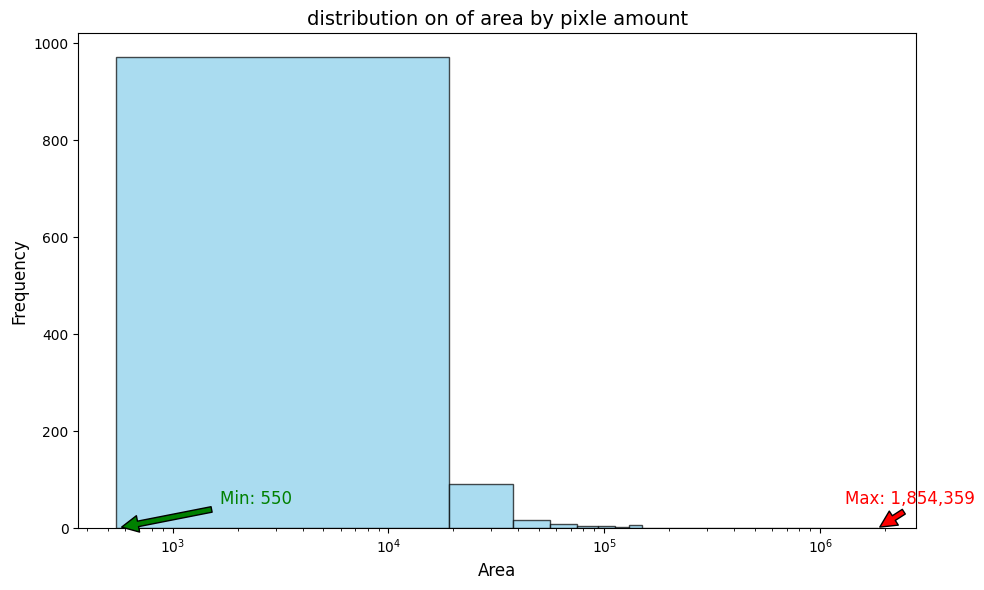

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming filtered_data is a dictionary of arrays
shapes = [list(filtered_data.values())[i].shape for i in range(len(filtered_data))]

# Compute the area (first two components multiplication) for each shape
areas = [shape[0] * shape[1] for shape in shapes if len(shape) >= 2]  # Ensure there are at least two dimensions

# Calculate min and max of areas
min_area = min(areas)
max_area = max(areas)

# Plot a histogram of the areas with improved appearance
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=100, edgecolor='black', color='skyblue', alpha=0.7)

# Add min and max to the plot title with improved formatting
plt.title('distribution on of area by pixle amount', fontsize=14)
plt.xlabel('Area', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Optionally, add text annotations for min and max on the plot with better positioning
plt.annotate(f'Min: {min_area:,}', xy=(min_area, 0), xytext=(min_area + min_area * 2, 50), 
             arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12, color='green')
plt.annotate(f'Max: {max_area:,}', xy=(max_area, 0), xytext=(max_area - max_area * 0.3, 50), 
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12, color='red')

# Apply log scale to the x-axis if needed
plt.xscale('log')

# Adjust tick label formatting for clarity
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



In [10]:
def augment_data_with_rotations(func_data: dict, func_labels: dict):
    data = func_data.copy()
    labels = func_labels.copy()
    # Collect original keys to avoid modifying the dictionary during iteration
    original_keys = list(data.keys())
    
    for key in original_keys:
        original_img = data[key]
        
        original_label = labels.get(key)
        for i in range(1, 4):  # Create 4 augmented versions
            
            rotated_img =  ndimage.rotate(original_img, random.randint(0, 360))
            rotated_img = adjust_size(rotated_img)
            new_key = f"{key}_{i}"
            if new_key in data or new_key in labels:
                raise KeyError(f"Key '{new_key}' already exists in data or labels dictionaries.")
            data[new_key] = rotated_img
            labels[new_key] = original_label
    for key in original_keys:
        original_img = data[key]        
        data[key] = adjust_size(original_img)
    return data,labels
updated_data,updated_labels = augment_data_with_rotations(filtered_data, Labels)

## Custom Dataset and DataLoader Creation for Train-Test Split

In [56]:

class CustomDataset(Dataset):
    def __init__(self, data_dict, labels_dict):
        self.data_items = list(data_dict.items())
        self.labels_dict = labels_dict

    def __len__(self):
        return len(self.data_items)

    def __getitem__(self, idx):
        id_, np_array = self.data_items[idx]
        tensor = torch.tensor(np_array, dtype=torch.float32)
        tensor = tensor.permute(2, 0, 1)  # Rearrange dimensions to [channels, height, width]
        label_value = self.labels_dict[id_]
        label = torch.tensor([label_value], dtype=torch.float32)  # Convert scalar to tensor
        return tensor, label
    
    def get_label_key(self, idx):
        id_, _ = self.data_items[idx]
        return id_
        
    def get_image_by_label(self, label):
            # Find the id_ corresponding to the label
            for id_, label_value in self.labels_dict.items():
                if id_ == label:
                    np_array = dict(self.data_items)[id_]  # Get the numpy array for the image
                    image_tensor = torch.tensor(np_array, dtype=torch.float32)
                    image_tensor = image_tensor.permute(2, 0, 1)  # Rearrange to [channels, height, width]
                    return image_tensor, self.labels_dict[id_]
            return None, None  # Return
    

data_items = list(updated_data.items())
labels_dict = updated_labels
data_keys = [key for key, _ in data_items]
data_values = [value for _, value in data_items]
train_keys, test_keys, train_values, test_values = train_test_split(
    data_keys, data_values, test_size=0.2, random_state=42
)

# Create train and test dictionaries
train_data_dict = {key: value for key, value in zip(train_keys, train_values)}
test_data_dict = {key: value for key, value in zip(test_keys, test_values)}

# Split the labels accordingly
train_labels_dict = {key: labels_dict[key] for key in train_keys}
test_labels_dict = {key: labels_dict[key] for key in test_keys}

train_dataset = CustomDataset(train_data_dict, train_labels_dict)
test_dataset = CustomDataset(test_data_dict, test_labels_dict)


dataset = CustomDataset(updated_data, labels_dict)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Modified ResNet-50 with 4-Channel Input and Adam Optimizer

In [57]:
model = models.resnet50(pretrained=True)

# Modify the first convolutional layer to accept 4 channels instead of 3
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 1)

dataset = CustomDataset(updated_data, labels_dict)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\anissan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anissan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##  Training and Model Deployment 

In [11]:
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Create a copy of inputs to apply cropping
        inputs_cropped = inputs.clone()
        
        inputs_cropped = inputs_cropped.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs_cropped)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs_cropped.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # Create a copy of inputs to apply cropping
            inputs_cropped = inputs.clone()
            
            # Apply cropping if needed for validation as well
            for i in range(len(inputs_cropped)):
                if inputs_cropped[i].shape[1] > 224 or inputs_cropped[i].shape[2] > 224:
                    inputs_cropped[i] = randomaly_crop(inputs_cropped[i], target_size=224)
                    
            inputs_cropped = inputs_cropped.to(device)
            labels = labels.to(device)

            outputs = model(inputs_cropped)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs_cropped.size(0)

    val_loss /= len(test_dataloader.dataset)
    torch.save(model.state_dict(), model_path)
    print(f'Model state_dict saved at epoch {epoch+1}')
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

Epoch 1/10, Training Loss: 1.0550
Model state_dict saved at epoch 1
Epoch 1/10, Validation Loss: 1.0613
Epoch 2/10, Training Loss: 0.8766
Model state_dict saved at epoch 2
Epoch 2/10, Validation Loss: 1.2688
Epoch 3/10, Training Loss: 0.6773
Model state_dict saved at epoch 3
Epoch 3/10, Validation Loss: 1.0491
Epoch 4/10, Training Loss: 0.4876
Model state_dict saved at epoch 4
Epoch 4/10, Validation Loss: 1.2603
Epoch 5/10, Training Loss: 0.3336
Model state_dict saved at epoch 5
Epoch 5/10, Validation Loss: 1.2704
Epoch 6/10, Training Loss: 0.2078
Model state_dict saved at epoch 6
Epoch 6/10, Validation Loss: 0.9462
Epoch 7/10, Training Loss: 0.1592
Model state_dict saved at epoch 7
Epoch 7/10, Validation Loss: 0.9500
Epoch 8/10, Training Loss: 0.1221
Model state_dict saved at epoch 8
Epoch 8/10, Validation Loss: 1.0317
Epoch 9/10, Training Loss: 0.1052
Model state_dict saved at epoch 9
Epoch 9/10, Validation Loss: 0.8860
Epoch 10/10, Training Loss: 0.1057
Model state_dict saved at epo

In [77]:
model.load_state_dict(torch.load(model_path))

def check_row(row,val0,val1,col1,col2):
    if val0 == row[col1] and val1 == row[col2]  :
        return True
    return False

def extract_name_label(label,response):
    if "_" in label:
        label = label.split('_')[0]
    val0,val1 =float(label.split(" ")[0]),float(label.split(" ")[1])
    return response[response.apply(check_row, axis=1, args=(val0, val1,col1,col2))]

C:\Users\anissan\AppData\Local\Temp\ipykernel_19772\2946675983.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [78]:
response.head()


,מעמד מוניציפלי,סמל יישוב,שם יישוב,NAME OF LOCALITY,אשכול 2021,אשכול 2019,סמל אזור סטטיסטי,אוכלוסיית המדד 2021,ערך מדד 2021,דירוג 2021,אשכול 2021.1,אשכול 2019.1,Unnamed: 12
0,0.0,31.0,אופקים,Ofaqim,3.0,3.0,6.0,"6,704",-1.576,144.0,2.0,1,NaN
1,0.0,31.0,אופקים,Ofaqim,3.0,3.0,3.0,"2,973",-1.133,240.0,2.0,3,NaN
2,0.0,31.0,אופקים,Ofaqim,3.0,3.0,4.0,"2,918",-1.022,264.0,3.0,3,NaN
3,0.0,31.0,אופקים,Ofaqim,3.0,3.0,2.0,"2,619",-0.650,373.0,3.0,4,NaN
4,0.0,31.0,אופקים,Ofaqim,3.0,3.0,1.0,"5,224",-0.622,384.0,3.0,4,NaN


In [83]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


# Function to apply Grad-CAM to the model
def apply_grad_cam(model, image, target_layer):
    # Lists to store the feature maps and gradients
    features = []
    gradients = []

    # Forward hook: store the feature maps
    def forward_hook(module, input, output):
        features.append(output)
    
    # Backward hook: store the gradients of the feature maps
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    
    # Register the hooks on the target layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass through the model
    output = model(image)
    
    # Backward pass to compute gradients
    model.zero_grad()
    output.backward()  # Backpropagate with respect to the output
    
    # Remove the hooks
    forward_handle.remove()
    backward_handle.remove()
    
    # Get the gradients and the feature maps
    gradients = gradients[0]
    features = features[0]
    
    # Global average pool the gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # Weight the feature maps with the pooled gradients
    for i in range(features.shape[1]):
        features[0, i, :, :] *= pooled_gradients[i]
    
    # Generate the Grad-CAM heatmap
    heatmap = torch.mean(features, dim=1).squeeze()
    heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1
    
    return heatmap, output


In [84]:

def find_top_bottom_5_percent_with_keys(data_dict,percent):
    # Sort the dictionary by values
    filtered_dict = {k: v for k, v in data_dict.items() if '_' not in k}

    # Sort the filtered dictionary by values
    sorted_items = sorted(filtered_dict.items(), key=lambda x: x[1])
    print(len(sorted_items))
    # Calculate 5% of the total number of elements
    n = len(sorted_items)
    percent_n = math.ceil(n * percent/100)  # Use ceil to always round up to include at least one element
    print(percent_n)
    # Get the top 5% largest and bottom 5% smallest
    smallest_5_percent = dict(sorted_items[:percent_n])
    largest_5_percent = dict(sorted_items[-percent_n:])

    # Merge the two dictionaries into one
    unified_dict = {**smallest_5_percent, **largest_5_percent}

    return unified_dict

extoridary_data = find_top_bottom_5_percent_with_keys(updated_labels,5)
for k,v in extoridary_data.items():
    names= extract_name_label(k,response)
    eshcol = names.loc[names.index[0],' אשכול 2021.1']
    yishuv = names.loc[names.index[0],names.columns[2]]
    
extreme_test_values = list(set(test_data_dict.keys()) & set(extoridary_data.keys()))

1110
56


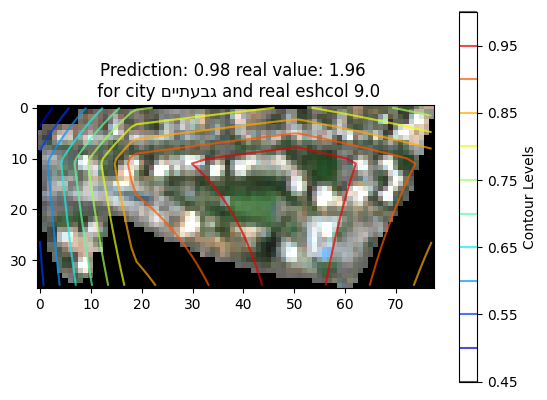

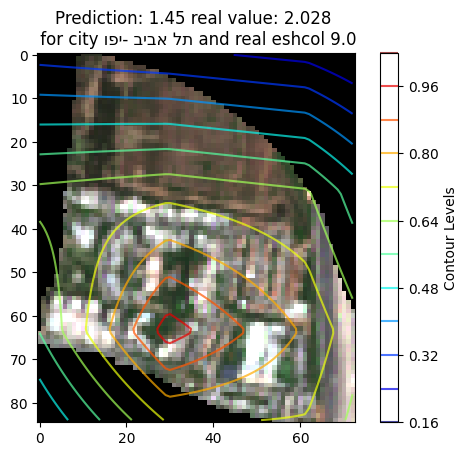

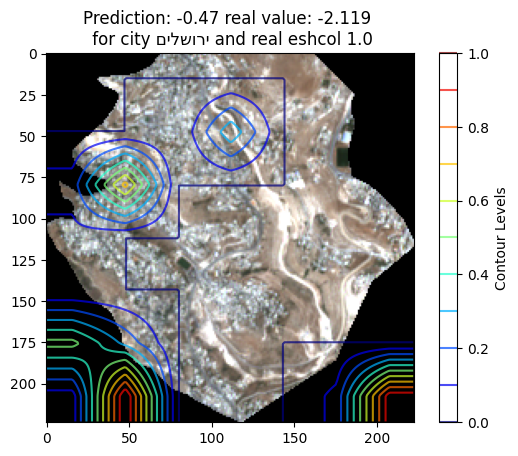

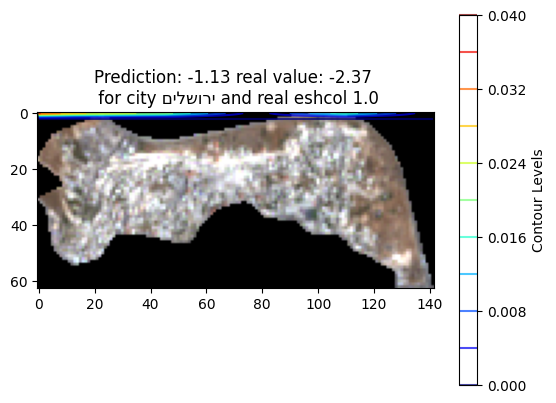

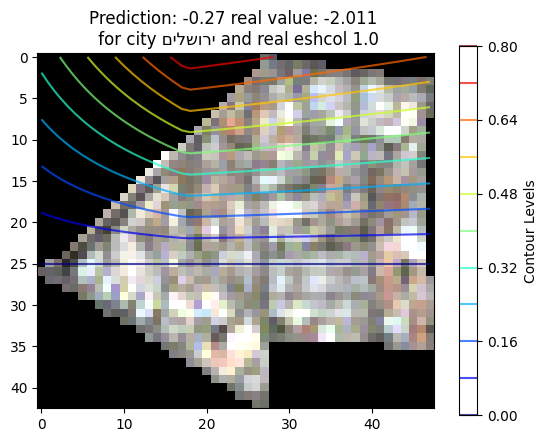

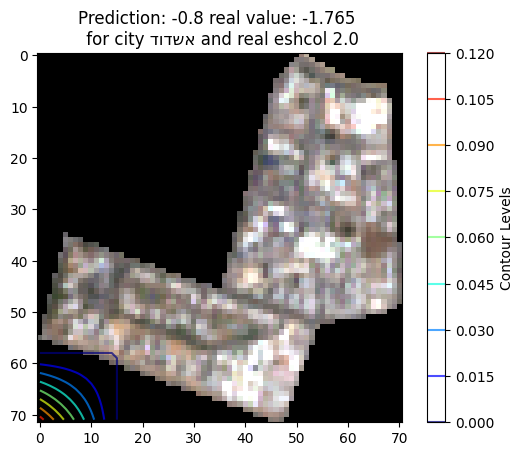

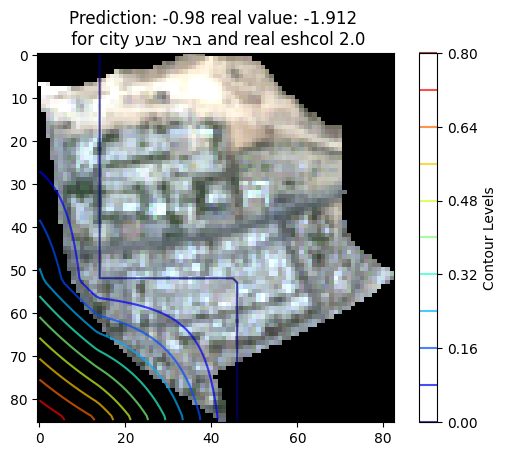

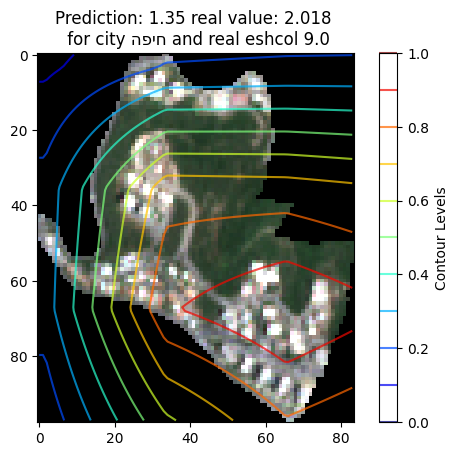

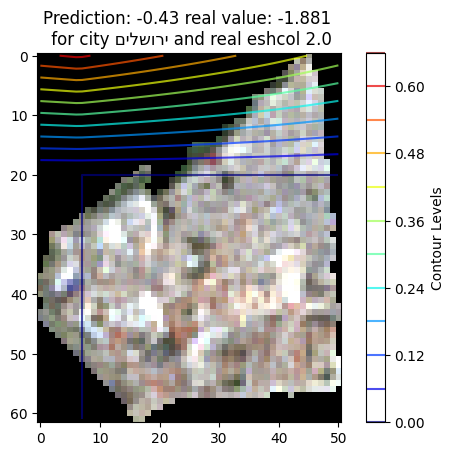

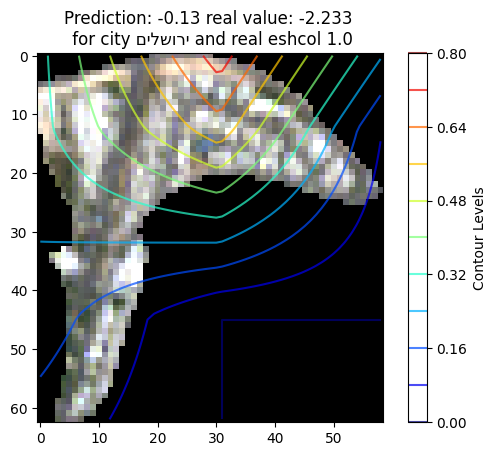

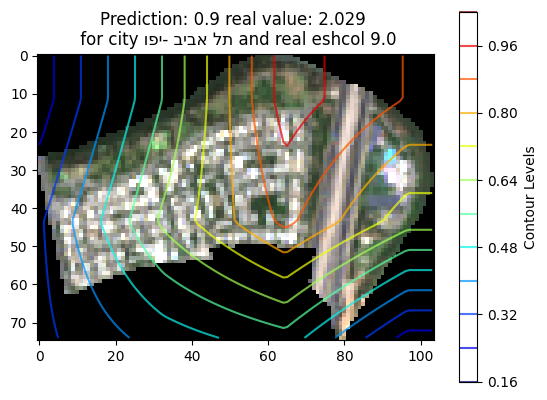

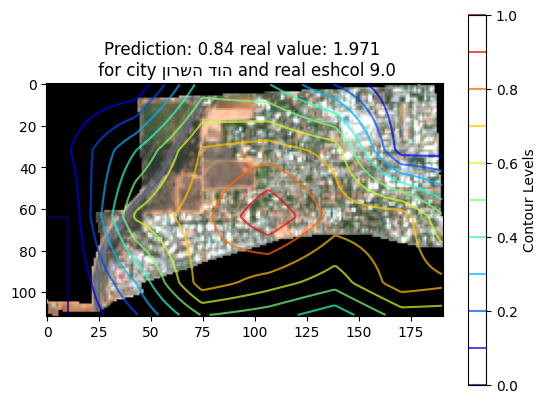

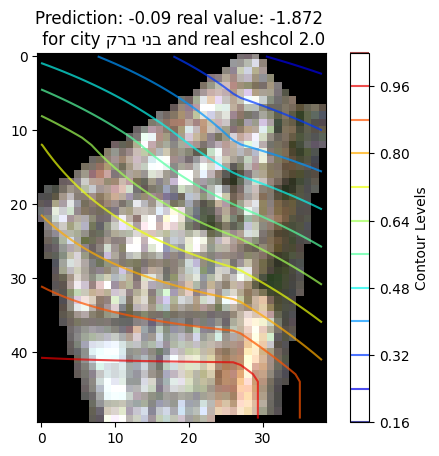

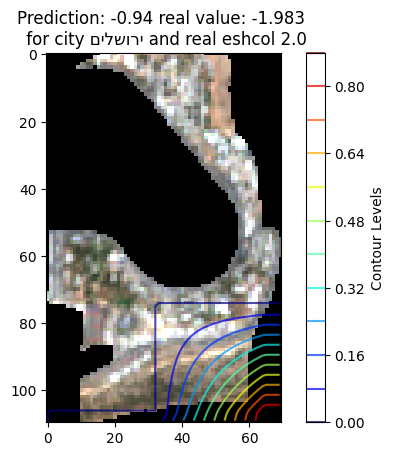

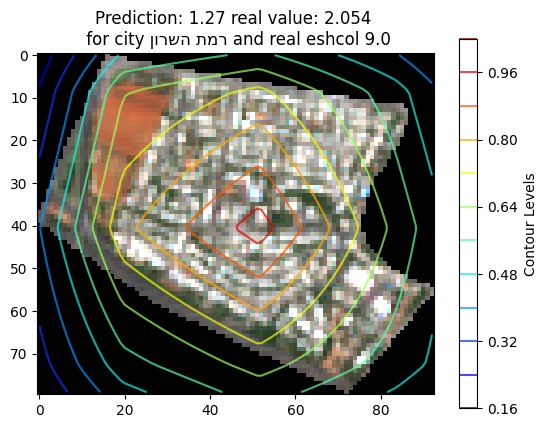

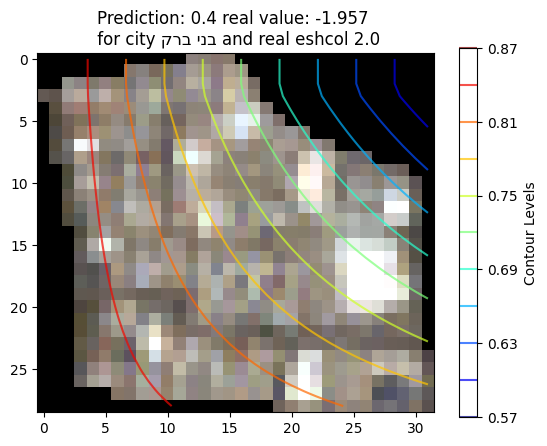

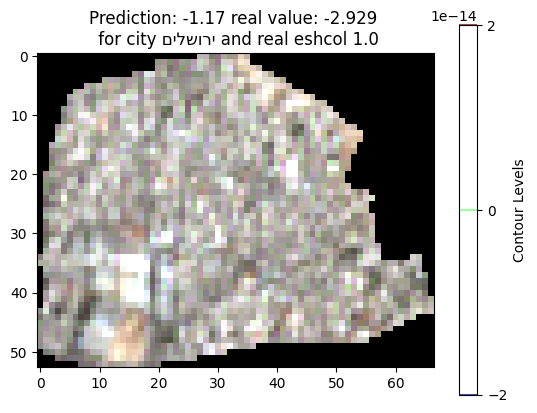

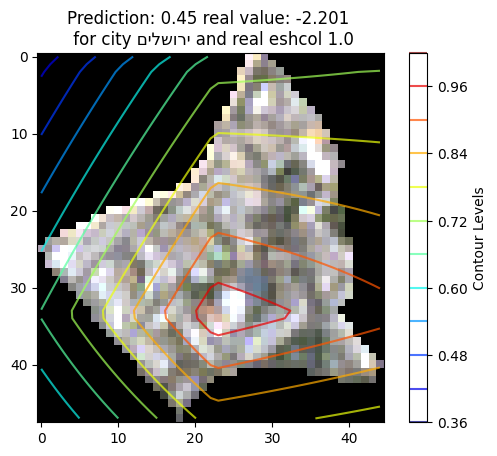

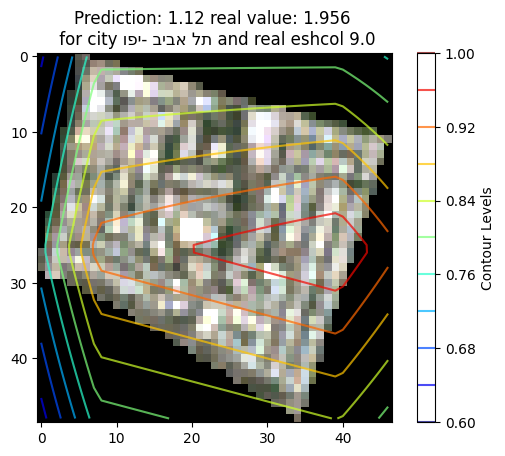

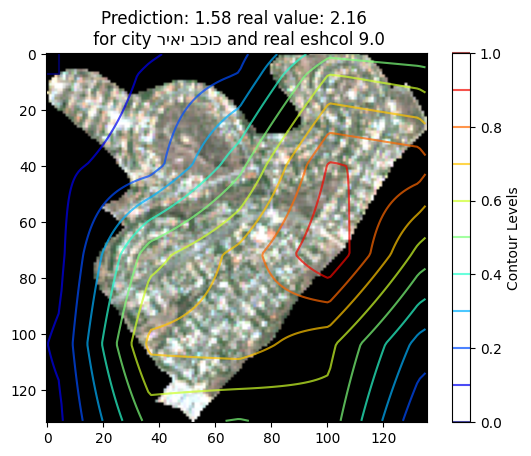

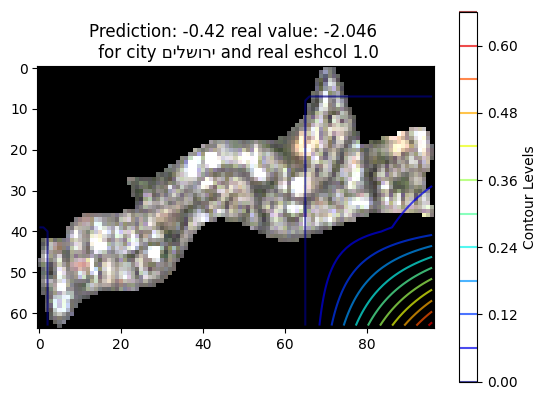

In [85]:
# Example of a function to crop an image based on non-zero values in the RGB channels
def crop_image_and_heatmap(image_np, heatmap_resized):
    # Identify the bounding box where the RGB channels have non-zero values
    mask = np.any(image_np[..., 1:4] != 0, axis=-1)
    
    # Find the indices of the non-zero regions in both dimensions
    rows = np.where(np.any(mask, axis=1))[0]
    cols = np.where(np.any(mask, axis=0))[0]
    
    # Define the cropping boundaries
    row_min, row_max = rows[0], rows[-1]
    col_min, col_max = cols[0], cols[-1]
    
    # Crop the image based on these boundaries
    cropped_image = image_np[row_min:row_max+1, col_min:col_max+1, ...]
    
    # Crop the heatmap to match the new image size
    cropped_heatmap = heatmap_resized[row_min:row_max+1, col_min:col_max+1]
    
    return cropped_image, cropped_heatmap


def plot_heat_map(label_d):
    idx = 15 # the sample idx
    # Assuming your test_dataset returns (image, label) and image has 4 channels
    image, val = test_dataset.get_image_by_label(label_d)  # Get the first test image and label
    
    # Preprocess the image and add batch dimension if needed
    image = image.unsqueeze(0)  # Add batch dimension
    
    # Get the target layer (typically the last convolutional layer)
    target_layer = model.layer4[-1]  # Last conv layer in ResNet-50 before the FC layer
    
    # Apply Grad-CAM and get the output
    heatmap, output = apply_grad_cam(model, image, target_layer)
    
    # Convert the image to numpy (you may need to adapt this if your image is not in a standard format)
    image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert image to numpy array (H, W, C)
    
    # Resize the heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    names= extract_name_label(label_d,response)
    eshcol = names.loc[names.index[0],' אשכול 2021.1']
    yishuv = names.loc[names.index[0],names.columns[2]]
    
    cropped_image, cropped_heatmap = crop_image_and_heatmap(image_np, heatmap_resized)



    # Plot the original image
    plt.imshow(cropped_image[..., [2,1,0]])  # Display only the RGB channels
    plt.title(f'Prediction: {round(output.item(),2)} real value: {val} \n for city {yishuv[::-1]} and real eshcol {eshcol}')  # Use the model output for the title
    
    # Superimpose contour lines from the heatmap
    contour = plt.contour(cropped_heatmap, levels=10, cmap='jet', alpha=0.7)  # Adjust levels for the number of contours

    # Add a colorbar (legend) to the contour plot
    plt.colorbar(contour, label="Contour Levels")

    # Show the plot
    plt.show()
    
for i in range(len(extreme_test_values)):
    plot_heat_map(extreme_test_values[i])

### Error analysis

The model captures some correlation between real and predicted values, though the scatter around the regression line suggests it may need improvement. It shows potential but is not fully reliable yet. 
We also checked if the coverage percentage had any significant effect on the predictions, but we did not find any consistent results.

In [74]:
pixle_precent = 100 / (224 * 224)

# Function to generate predictions and scatter plot real vs predicted
def prepare_data_scatter_plot_real_vs_pred(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    pixel_percentages = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Calculate pixel percentage for the current batch
            for i in range(inputs.shape[0]):  # Loop over batch size
                pixel_percent = ((inputs[i] != 0).sum(dim=0) == 4).sum().item() * pixle_precent
                pixel_percentages.append(pixel_percent)
            # Get predictions from the model
            outputs = model(inputs)

            # Convert outputs and labels to CPU for plotting
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Flattening the lists
    all_preds = [item for sublist in all_preds for item in sublist]
    all_labels = [item for sublist in all_labels for item in sublist]
    pixel_percentages = np.array(pixel_percentages)  # Convert pixel percentages to numpy array
    return all_preds, all_labels, pixel_percentages

# Call the function after training the model
all_preds, all_labels, pixel_percentages = prepare_data_scatter_plot_real_vs_pred(model, test_dataloader, device)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     276.8
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           2.68e-54
Time:                        23:11:53   Log-Likelihood:                -960.11
No. Observations:                 888   AIC:                             1924.
Df Residuals:                     886   BIC:                             1934.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0569      0.024     -2.354      0.0

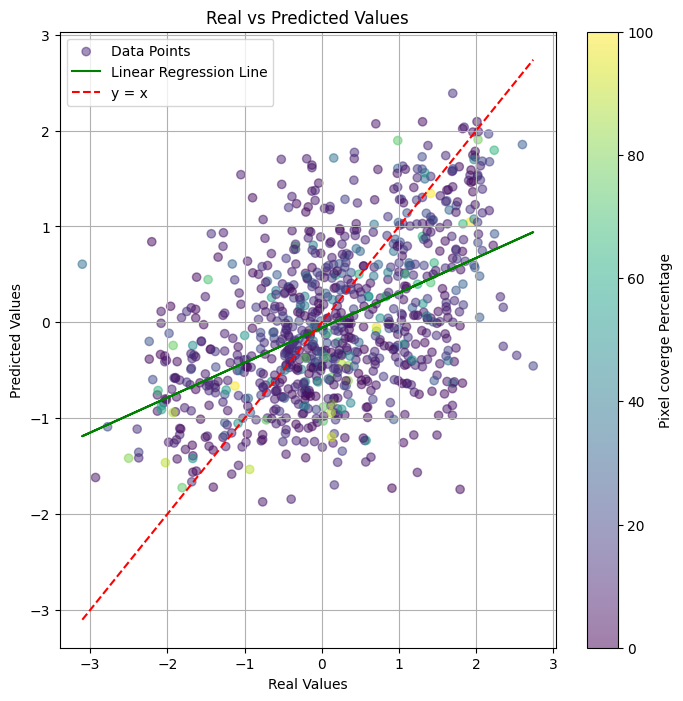

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1352
Date:                Sun, 15 Sep 2024   Prob (F-statistic):              0.713
Time:                        23:11:53   Log-Likelihood:                -1256.8
No. Observations:                 888   AIC:                             2518.
Df Residuals:                     886   BIC:                             2527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1347      0.045      3.023      0.0

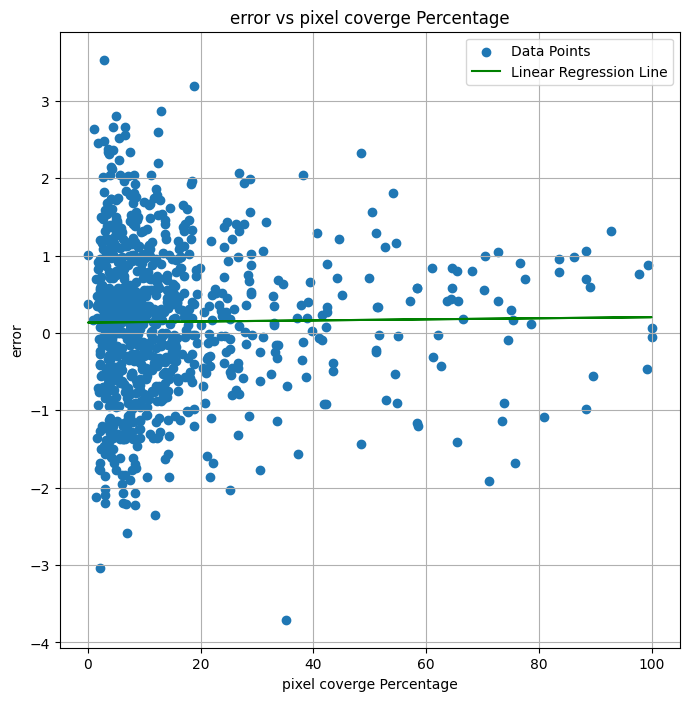

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.239
Date:                Sun, 15 Sep 2024   Prob (F-statistic):             0.0127
Time:                        23:11:54   Log-Likelihood:                -1610.5
No. Observations:                 888   AIC:                             3225.
Df Residuals:                     886   BIC:                             3235.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1235      0.066     16.927      0.0

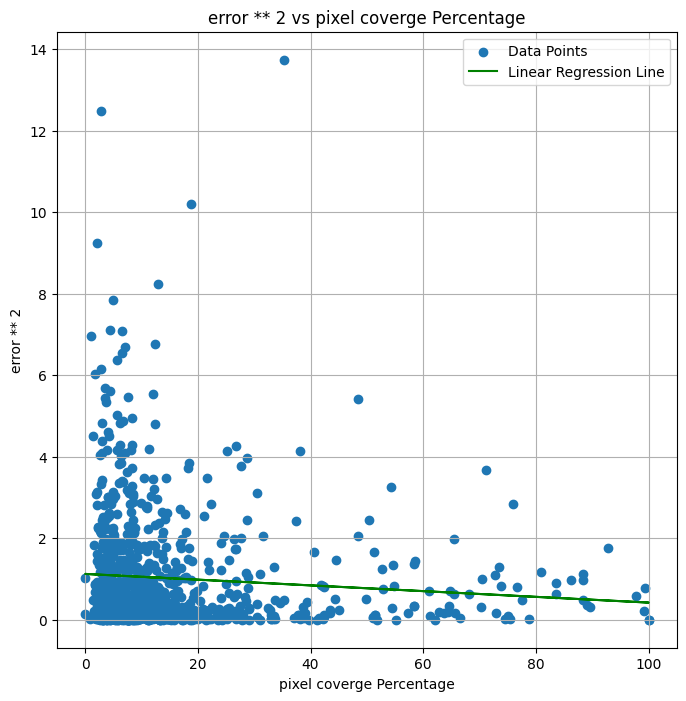

In [75]:
def scatter_plot_real_vs_pred(all_preds, all_labels, pixel_percentages):
    # Convert to NumPy arrays for use in regression
    X = np.array(all_labels)
    y = np.array(all_preds)

    # Add a constant to the independent variable matrix for intercept
    X_with_const = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    # Print the regression summary (including p-values, coefficients, R-squared, etc.)
    print(results.summary())

    # Generate predicted values for the regression line
    y_pred_line = results.predict(X_with_const)

    # Plot scatter plot for real vs predicted values with color based on pixel percentage
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(all_labels, all_preds, c=pixel_percentages, alpha=0.5, cmap='viridis', label='Data Points')
    plt.plot(X, y_pred_line, color='green', label='Linear Regression Line')  # Linear regression line
    plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='r', linestyle='--', label='y = x')  # Line for y = x
    plt.title('Real vs Predicted Values')
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.colorbar(scatter, label='Pixel coverge Percentage')  # Add color bar for pixel percentage
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Convert to NumPy arrays for use in regression
    y = (np.array(all_labels) - np.array(all_preds))
    X = np.array(pixel_percentages)

    # Add a constant to the independent variable matrix for intercept
    X_with_const = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    y_pred_line = results.predict(X_with_const)

    # Print the regression summary (including p-values, coefficients, R-squared, etc.)
    print(results.summary())
    
        # Plot scatter plot for real vs predicted values with color based on pixel percentage
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(X, y, label='Data Points')
    plt.plot(X, y_pred_line, color='green', label='Linear Regression Line')  # Linear regression line
    plt.title('error vs pixel coverge Percentage')
    plt.xlabel('pixel coverge Percentage')
    plt.ylabel('error')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Convert to NumPy arrays for use in regression
    y = (np.array(all_labels) - np.array(all_preds))**2
    X = np.array(pixel_percentages)

    # Add a constant to the independent variable matrix for intercept
    X_with_const = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    y_pred_line = results.predict(X_with_const)

    # Print the regression summary (including p-values, coefficients, R-squared, etc.)
    print(results.summary())
    
        # Plot scatter plot for real vs predicted values with color based on pixel percentage
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(X, y, label='Data Points')
    plt.plot(X, y_pred_line, color='green', label='Linear Regression Line')  # Linear regression line
    plt.title('error ** 2 vs pixel coverge Percentage')
    plt.xlabel('pixel coverge Percentage')
    plt.ylabel('error ** 2')
    plt.grid(True)
    plt.legend()
    plt.show()


# Call the function after training the model
scatter_plot_real_vs_pred(all_preds, all_labels, pixel_percentages)
